In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from skimage.io import imsave, imread

import rasterio
from rasterio.features import shapes
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, accuracy_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import pyplot

# VARIABLES AND FOLDERS

In [2]:
project_path = "./"
sat_img_folders = "landsat_8_2022" # "landsat_5_2010" # "landsat_7_1999" # 

img_path = "./muestras/"+sat_img_folders+"/"
img_sat_aoi_folder = "./aoi/"+sat_img_folders+"/"
img_sat_aoi = "./aoi/"+sat_img_folders+"/area_de_estudio_"+sat_img_folders+".tif"

In [3]:
img_list = os.listdir(img_path)
muestras_list = []
for i in img_list:
    muestras_list.append([i.split("_")[0],i])
print(len(muestras_list))
print(muestras_list)

56
[['darkwater', 'darkwater_11_10.tif'], ['darkwater', 'darkwater_12_11.tif'], ['darkwater', 'darkwater_16_14.tif'], ['darkwater', 'darkwater_17_15.tif'], ['darkwater', 'darkwater_8_7.tif'], ['sand', 'sand_18_16.tif'], ['sand', 'sand_19_17.tif'], ['sand', 'sand_20_18.tif'], ['sand', 'sand_21_19.tif'], ['sand', 'sand_22_20.tif'], ['sand', 'sand_23_21.tif'], ['sand', 'sand_24_22.tif'], ['sand', 'sand_25_23.tif'], ['sand', 'sand_27_24.tif'], ['sand', 'sand_28_25.tif'], ['tngreen', 'tngreen_36_32.tif'], ['tng', 'tng_41_39.tif'], ['tng', 'tng_42_40.tif'], ['tng', 'tng_43_41.tif'], ['tng', 'tng_48_46.tif'], ['tng', 'tng_48_47.tif'], ['tng', 'tng_56_55.tif'], ['tnlow', 'tnlow_36_34.tif'], ['tnlow', 'tnlow_52_51.tif'], ['tnlow', 'tnlow_54_52.tif'], ['tnlow', 'tnlow_56_54.tif'], ['tn', 'tn_31_27.tif'], ['tn', 'tn_32_28.tif'], ['tn', 'tn_33_29.tif'], ['tn', 'tn_34_30.tif'], ['tn', 'tn_35_31.tif'], ['tn', 'tn_37_36.tif'], ['tn', 'tn_38_37.tif'], ['tn', 'tn_40_38.tif'], ['tn', 'tn_49_48.tif'], ['

In [4]:
df_img = pd.DataFrame([], columns=['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'evi', 'gndvi', 'MSI', 'NDBI', 'NDMI', 'ndvi', 'NDWI', 'savi', "class"])

for m in range(len(muestras_list)):

    img = imread(img_path+muestras_list[m][1])

    for i in range(len(img)):
        df_img_col = pd.DataFrame(img[i], columns=['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'evi', 'gndvi', 'MSI', 'NDBI', 'NDMI', 'ndvi', 'NDWI', 'savi', ])
        df_img_col['class'] = muestras_list[m][0]
        df_img = pd.concat([df_img, df_img_col])

In [5]:
print(len(df_img))
df_img = df_img.loc[(df_img.b2 != 0) & (df_img.b3 != 0) & (df_img.b4 != 0)]
df_img.loc[(df_img['class'] == 1) | (df_img['class'] == 2)]
df_img.replace([np.inf, -np.inf], np.nan, inplace=True)
df_img.dropna(how="all", inplace=True)
df_img.fillna(0, inplace=True)
df_img.reset_index(inplace=True, drop=True)
for c in list(df_img.columns):
    if c != 'class':
        df_img[c] = df_img[c].astype(float)
print(len(df_img))
df_img.head()

247496
240786


,b1,b2,b3,b4,b5,b6,b7,evi,gndvi,MSI,NDBI,NDMI,ndvi,NDWI,savi,class
0,163.0,136.0,162.0,65.0,29.0,162.0,29.0,0.096154,-0.025641,0.289474,-0.551020,0.551020,-0.182796,0.025641,-0.945866,darkwater
1,165.0,141.0,165.0,62.0,20.0,162.0,14.0,0.114025,-0.051282,0.189189,-0.681818,0.681818,-0.212766,0.051282,-1.108214,darkwater
2,163.0,141.0,164.0,65.0,20.0,154.0,14.0,0.103211,-0.037975,0.184211,-0.688889,0.688889,-0.191489,0.037975,-1.103172,darkwater
3,166.0,141.0,164.0,65.0,20.0,154.0,22.0,0.099778,-0.037975,0.184211,-0.688889,0.688889,-0.191489,0.037975,-1.103172,darkwater
4,152.0,141.0,164.0,65.0,20.0,154.0,15.0,0.108827,-0.037975,0.184211,-0.688889,0.688889,-0.191489,0.037975,-1.103172,darkwater


In [5]:
df_img.loc[df_img['class']=='tngreen', ['class']] = 'tng'

In [6]:
for i, c in enumerate(list(df_img['class'].unique())):
    df_img.loc[df_img['class']==c, ['class']] = i
    print(i,c)
print(list(df_img['class'].unique()))

0 darkwater
1 sand
2 tng
3 tnlow
4 tn
5 urban
6 water
[0, 1, 2, 3, 4, 5, 6]


### TRAIN

In [13]:
df_img.loc[df_img['class']!=5, 'class'] = 0
df_img.loc[df_img['class']==5, 'class'] = 1

In [14]:
X = df_img.drop(columns='class')
y = df_img.loc[:,'class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42, stratify=y)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.87374
1    0.12626
Name: class, dtype: float64
0    0.873745
1    0.126255
Name: class, dtype: float64


In [15]:
y=y.astype('int')
y_train=y_train.astype('int')
y_test=y_test.astype('int')

for k in range(1,15,1):                      
    clf = KNeighborsClassifier(k)
    clf.fit(X_train.astype(int), y_train.astype(int))
    score = clf.score(X_test, y_test)
    print('score: ',score, ' - k: ', k)

score:  0.9686746137280975  - k:  1
score:  0.9879028936560798  - k:  2
score:  0.9891149578131068  - k:  3
score:  0.9884912743148307  - k:  4
score:  0.9890443521340566  - k:  5
score:  0.9885736476070559  - k:  6
score:  0.9888678379364314  - k:  7
score:  0.9885736476070559  - k:  8
score:  0.9888089998705563  - k:  9
score:  0.9886207180597559  - k:  10
score:  0.9887619294178561  - k:  11
score:  0.9884677390884807  - k:  12
score:  0.9885148095411808  - k:  13
score:  0.9883618305699055  - k:  14


### PREDICT

In [16]:
modelo = KNeighborsClassifier(10)
modelo.fit(X, y)
print("score:", modelo.score(X, y))

y_pred_model = modelo.predict(X)
confusion_matrix(y, y_pred_model)

score: 0.9895879423477024


array([[185292,    331],
       [  1881,  24942]], dtype=int64)

Text(0.5, 80.7222222222222, 'Valores predichos')

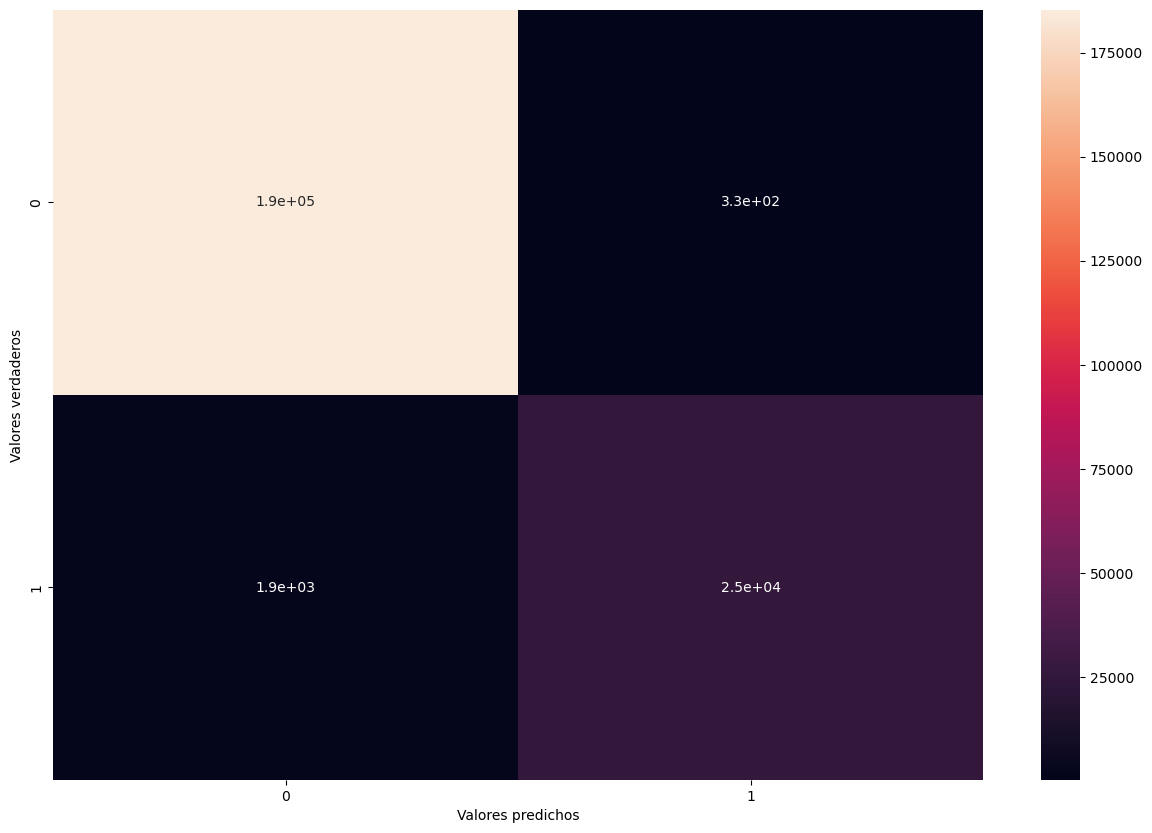

In [17]:
fig, ax = pyplot.subplots(figsize=(15,10))
sns.heatmap(confusion_matrix(y, y_pred_model), annot=True)
plt.ylabel('Valores verdaderos')
plt.xlabel('Valores predichos')

In [18]:
img_sat = imread(img_sat_aoi)
col_dim = len(img_sat)
row_dim = len(img_sat[0])
band_dim = len(img_sat[0][0])
print(col_dim, "x", row_dim, "=", col_dim*row_dim)

img_sat_reshape = img_sat.reshape(col_dim * row_dim, band_dim)
df_img_sat = pd.DataFrame(img_sat_reshape, columns=['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'evi', 'gndvi', 'MSI', 'NDBI', 'NDMI', 'ndvi', 'NDWI', 'savi'])

896 x 1374 = 1231104


In [19]:
df_img_sat.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_img.dropna(how="all", inplace=True)
df_img_sat.fillna(0, inplace=True)
df_img_sat.reset_index(inplace=True, drop=True)
print(len(df_img_sat))
df_img_sat.head(3)

1231104


,b1,b2,b3,b4,b5,b6,b7,evi,gndvi,MSI,NDBI,NDMI,ndvi,NDWI,savi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
y_pred = modelo.predict(df_img_sat)
df_img_sat['clase'] = y_pred

### EXPORT IMG

In [21]:
""" def color_class_index(df):
    df['clase_2'] = 0
    df.loc[df.clase == 5, 'clase_2'] = 1
    df.loc[df.clase != 5, 'clase_2'] = 2

    return df.loc[:,['clase_2']]

df_img_2 = df_img_sat.copy()
df_img_2 = color_class_index(df_img_2)
df_img_2 = df_img_2['clase_2'] """

df_img_2 = df_img_sat['clase']

lista_pixels = []
for d in range(len(img_sat)):
    first_pixel = len(img_sat[0]) * d
    last_pixel = len(img_sat[0]) * (d+1)
    row = [l for l in df_img_2[first_pixel:last_pixel].values]
    lista_pixels.append(row)
lista_pixels = np.array(lista_pixels)
print(lista_pixels.shape)
imsave(img_sat_aoi_folder+"area_de_estudio_"+sat_img_folders+"_class.tif", lista_pixels)

(896, 1374)


C:\Users\Compumar\AppData\Local\Temp\ipykernel_10504\3628152368.py:22: UserWarning: ./aoi/landsat_8_2022/area_de_estudio_landsat_8_2022_class.tif is a low contrast image
  imsave(img_sat_aoi_folder+"area_de_estudio_"+sat_img_folders+"_class.tif", lista_pixels)


In [22]:
# load classify image
img_not_georef_open = rasterio.open(img_sat_aoi_folder+"area_de_estudio_"+sat_img_folders+"_class.tif")
img_not_georef = img_not_georef_open.read()
# load a band of the original satellite image
img_georef_open = rasterio.open(img_sat_aoi_folder+'area_de_estudio_'+sat_img_folders+'.tif')
img_georef = img_georef_open.read(1)

# extract and modify the original image metadata
meta = img_georef_open.meta
meta.update(count=1)

# replace the array values
img_georef = img_not_georef[0]

# save the image with modify values
with rasterio.open(img_sat_aoi_folder+"area_de_estudio_"+sat_img_folders+"_class_georef.tif", 'w', **meta) as dst:
    dst.write(np.array([img_georef]).astype(rasterio.float32)) 

img_not_georef_open.close()
img_georef_open.close()
dst.close()

c:\Users\Compumar\anaconda3\envs\GeoAnalysis_Raste\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


### POLYGONIZE

In [23]:
mask = None
with rasterio.Env():
    with rasterio.open(img_sat_aoi_folder+'area_de_estudio_'+sat_img_folders+'_class_georef.tif') as src:
        image = src.read(1) # first band
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(
                shapes(image, mask=mask, transform=src.transform))
        )
src.close()
gpd_polygonized_raster = gpd.GeoDataFrame.from_features(list(results)) 
gpd_polygonized_raster = gpd_polygonized_raster.set_crs('epsg:32621')
gpd_polygonized_raster.to_file("./shp/poly_raster_"+sat_img_folders+".shp")
gpd_polygonized_raster.loc[gpd_polygonized_raster.raster_val == 1].to_file("./shp/poly_raster_urban_"+sat_img_folders+".shp")